# Summary
This notebook performs the experimentation to get the best model and features\
to predict how many states an olive will grow in 14 days.

- Obtained a model that outperforms the baseline. This is the lightgbm model.
- The predictive features used are: ['estado_mayoritario',
 'week_number',
 'days_in_current_state',
 'campaña',
 '102_coordenada_x_(utm)',
 '103_coordenada_y_(utm)',
 'LST_mean_365D',
 'LST_std_365D',
 'LST_median_365D',
 'LST']
- The metric results of the lightgbm model in test:
  - accuracy: 0.7476235527323513
  - mse: 0.27958733162139027
  - precision_for_class: [0.86795887 0.64121769 0.59095841 0.6969697 ]
  - recall_for_class: [0.83177815 0.72404856 0.61038476 0.15927978]
  - f1_for_class: [0.84948343 0.68012044 0.60051452 0.25930101]
  - confusion_matrix:
    \[[9538 1897   30    2]
     \[1408 5308  606    9]
     \[  40  964 1634   39]
     \[   3  109  495  115]]
- The metric results of the baseline in test:
  - accuracy: 0.6591431274496553
  - mse: 0.4575393071135739
  - precision_for_class: [0.75273694 0.5095332  0.62638581 0.        ]
  - recall_for_class: [0.83945234 0.52857727 0.42211431 0.        ]
  - f1_for_class: [0.79373325 0.51888056 0.50435171 0.        ]
  - confusion_matrix:
    \[[9626 1799   42    0]
     \[2948 3875  508    0]
     \[ 200 1347 1130    0]
     \[  14  584  124    0]]

## NEXT STEPS:
  - Categorical features were not used, their usage could improve the model.
  - The treatment for missing values in the meteo dataset was LOCF, try with\
    different approaches. Same for numerical features in the parcelas dataset,\
    where imputation with the mean was used.
  - Create more features. In our model, the features that we created were\
    the most important features when making a prediction.
  - Use the entire dataset given. The parcelas and meteo data used in this\
    experimentation was between 2018 and 2022 (inclusive), but did not use\
    the 2023 data, as it was given much later.

# Experimentation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import sys

In [2]:
sys.path.insert(0, str(Path("../../").resolve()))

from src.features import create_feature_frame, generate_target
from src.models import train_test_split, feature_label_split, baseline

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

## Load feature frames

In [3]:
from src.load import load_parcelas_feature_frame
from src.load_meteo import load_meteo_feature_frame

df_parcelas = load_parcelas_feature_frame()
df_meteo = load_meteo_feature_frame()

INFO:root:Executing load_parcelas_feature_frame
INFO:root:Loading dataset from /Users/jianingxu/Documents/repositories/courses/zrive-ds-1q24-olive-stage-prediction/src/notebooks_jianing/../../data/parcelas_feature_frame.parquet
INFO:root:Executing load_meteo_feature_frame
INFO:root:Loading dataset from /Users/jianingxu/Documents/repositories/courses/zrive-ds-1q24-olive-stage-prediction/src/notebooks_jianing/../../data/meteo_feature_frame.parquet


## Evaluation defitinion

In [4]:
from src.metrics import evaluate_classification, log_metrics, evaluate_configuration


def plot_feature_importance(model, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, model.feature_importances_)),
        columns=["features", "importance"],
    ).sort_values(by="importance", ascending=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fi, fig, ax


models_metric_results = {}

def save_model(model: Pipeline, model_name: str, models: dict):
    models[model_name] = model

models = {}

## Baseline

In [25]:
baseline_parcelas = generate_target(df_parcelas)
baseline_train_df, baseline_test_df = train_test_split(
    baseline_parcelas, split_year=2021, max_year=2022
)
baseline_result = baseline(baseline_train_df, baseline_test_df, "target")[
    ["codparcela", "fecha", "target", "y_pred"]
]
models_metric_results["baseline"] = {
    "test": evaluate_classification(
        baseline_result["target"], baseline_result["y_pred"].round()
    )
}
log_metrics("baseline", models_metric_results["baseline"]["test"])

INFO:src.metrics:Computed Metrics for baseline:
INFO:src.metrics:accuracy: 0.6591431274496553
INFO:src.metrics:mse: 0.4575393071135739
INFO:src.metrics:precision_for_class: [0.75273694 0.5095332  0.62638581 0.        ]
INFO:src.metrics:recall_for_class: [0.83945234 0.52857727 0.42211431 0.        ]
INFO:src.metrics:f1_for_class: [0.79373325 0.51888056 0.50435171 0.        ]
INFO:src.metrics:confusion_matrix:
[[9626 1799   42    0]
 [2948 3875  508    0]
 [ 200 1347 1130    0]
 [  14  584  124    0]]
INFO:src.metrics:----------------------------------


## ML pipeline

In [55]:
### I won't use columns with more than 80% of nulls
PHENOLOGICAL_STATE_COLS = [f"estado_fenologico_{i}" for i in range(14, 0, -1)]

parcelas_numerical_cols = ['campaña','porcentaje_floracion','102_coordenada_x_(utm)',
        '103_coordenada_y_(utm)', '104_altitud_(m)','201_superf_cultivada_en_la_parcela_agrícola_(ha)',
        '202_pendiente_(%)', '302_densidad_(plantas_ha)', '303_nº_pies_por_árbol',
        '305_diámetro_de_copa_(m)','317_%_superficie_ocupada_variedad_secundaria',
        '306_altura_de_copa_(m)', 'estado_mayoritario']

parcelas_categorical_cols = ['codparcela', '105_comarca', '203_orientación', '204_textura_del_suelo',
       '206_secano_/_regadío', '211_utilización_de_cubierta_vegetal',
       '212_tipo_de_cubierta_vegetal',
       '214_cultivo_asociado/otro_aprovechamiento', '301_marco_(m_x_m)',
       '304_formación', '308_variedad_principal',
       '311_fecha_de_plantación_variedad_principal',
       '208_riego:_procedencia_del_agua', '209_riego:_calidad_del_agua',
       '313_variedad_secundaria', '107_zona_homogénea',
       '120_zona_biológica_raif', '401_estación_climática_asociada',
       '402_sensor_climático_asociado', '207_riego:_sistema_usual_de_riego',
       '108_u_h_c_a_la_que_pertenece',
       '316_fecha_de_plantación_variedad_secundaria',
       '315_patrón_variedad_secundaria', '310_patrón_variedad_principal',
       '411_representa_a_la_u_h_c_(si/no)',
       '109_sistema_para_el_cumplimiento_gestión_integrada']

meteo_numerical_cols = ['lat', 'lon', 'FAPAR', 'GNDVI', 'LST',
                         'NDVI', 'NDWI', 'SAVI', 'SIPI', 'SSM']

label_col = 'target'

parcelas_created_features_cols = ['week_number', 'days_in_current_state', 'days_in_previous_state']


### Correlation matrix - HACERLA CON TODAS LAS VARIABLES NUMÉRICAS DE CLIMA Y PARCELAS Y EL TARGET

In [16]:
feature_frame = create_feature_frame(
    df_parcelas, df_meteo, parcelas_numerical_cols + parcelas_created_features_cols, []
)

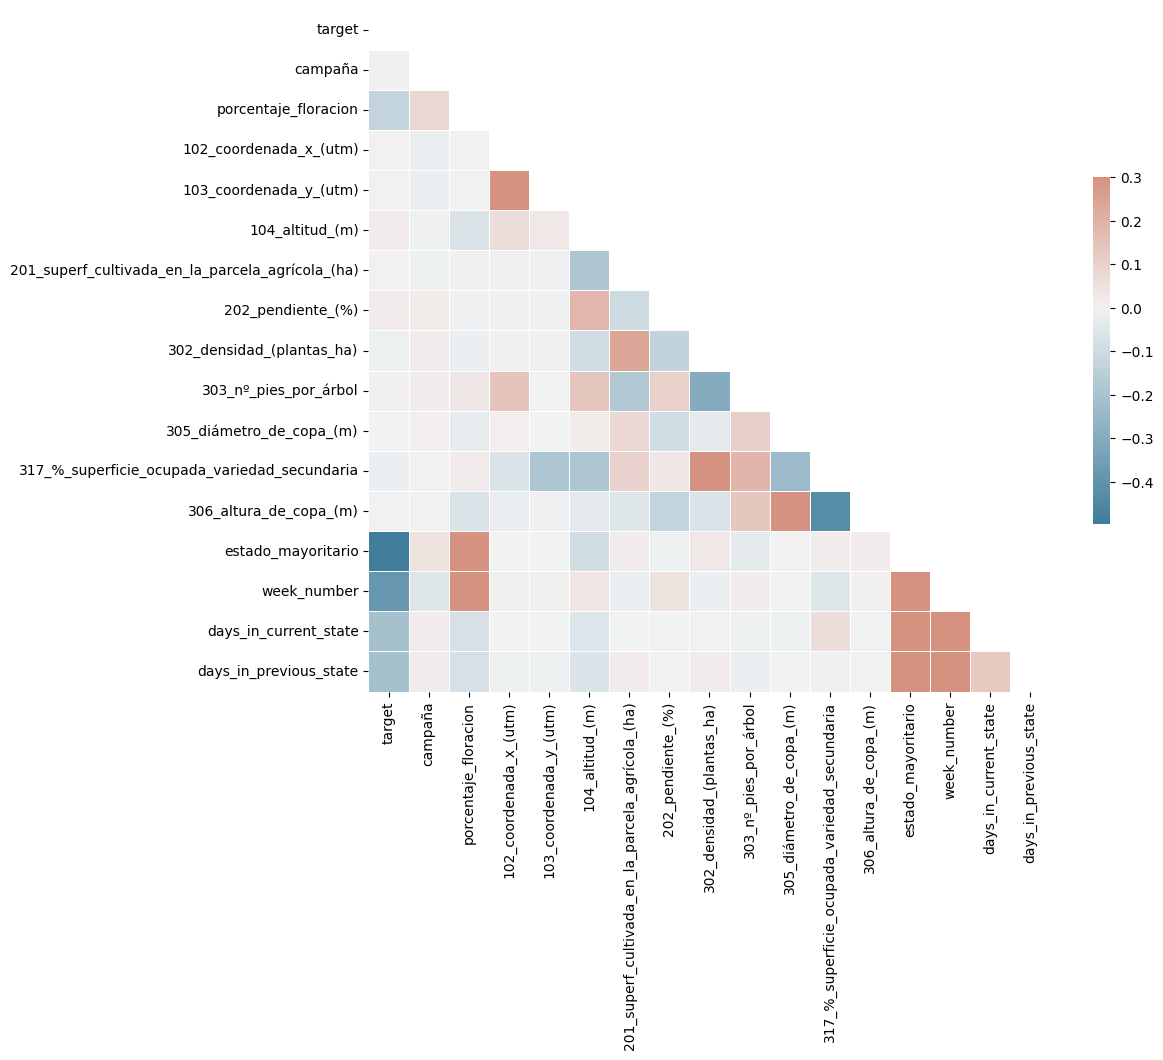

In [17]:
numerical_df = feature_frame.select_dtypes(include=['number'])
# filtered_numerical_df = numerical_df.loc[:, ~numerical_df.columns.str.startswith('estado_')]

def plot_correlation_matrix(df_):
    # Compute the correlation matrix
    corr = df_.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
plot_correlation_matrix(numerical_df)
# plot_correlation_matrix(filtered_numerical_df)

## Parcelas numerical and created features experimentation

### Linear Models: Lasso and Ridge Logistic Regression

In [53]:
def preprocess_data(
    df_parcelas: pd.DataFrame,
    df_meteo: pd.DataFrame,
    columns_parcela: list[str],
    columns_meteo: list[str],
):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"

    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)

    numerical_processor = Pipeline(
        steps=[
            ("imputation_mean", SimpleImputer(strategy="mean")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", numerical_processor, columns_parcela + columns_meteo),
        ]
    )

    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Use get_feature_names_out to get the transformed column names
    transformed_names = preprocessor.get_feature_names_out()

    # Create DataFrames with the transformed names
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=transformed_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_names)

    return X_train_preprocessed, y_train.array, X_test_preprocessed, y_test.array

In [56]:
# train test split with only parcelas numerical columns
selected_parcelas_cols = parcelas_numerical_cols + parcelas_created_features_cols
X_train, y_train, X_test, y_test = preprocess_data(
    df_parcelas=df_parcelas,
    df_meteo=df_meteo,
    columns_parcela=selected_parcelas_cols,
    columns_meteo=[],
)

#### Lasso Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    model_name = f"lr_l1_parcelas_numerical_c_{c}"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l1", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, models_metric_results)
    save_model(lr, model_name, models)

INFO:src.metrics:Computed Metrics for lr_l1_parcelas_numerical_c_1e-08_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_l1_parcelas_numerical_c_1e-08_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[11467     0     0     

No matter the regularization, the performance is the same.

#### Ridge Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    model_name = f"lr_l2_parcelas_numerical_c_{c}"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l2", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, models_metric_results)
    save_model(lr, model_name, models)

INFO:src.metrics:Computed Metrics for lr_l2_parcelas_numerical_c_1e-08_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_l2_parcelas_numerical_c_1e-08_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[11467     0     0     

Lasso and Ridge have same performance.
Optimal c=0.01, 1, 100, 10000.

#### Feature importance with linear models

In [23]:
best_model_name_lr_l1 = max(
    models_metric_results,
    key=lambda x: models_metric_results[x]["test"]["accuracy"] if "l1" in x else 0,
)
best_model_lr_l1 = models[best_model_name_lr_l1]
best_model_lr_l1_coeff = pd.DataFrame(
    {
        "features": X_train.columns,
        "importance": np.abs(best_model_lr_l1.named_steps["lr"].coef_[0]),
        "regularisation": ["l1"] * len(X_train.columns),
    }
)
best_model_lr_l1_coeff = best_model_lr_l1_coeff.sort_values(
    "importance", ascending=True
)


best_model_name_lr_l2 = max(
    models_metric_results,
    key=lambda x: models_metric_results[x]["test"]["accuracy"] if "l2" in x else 0,
)
best_model_lr_l2 = models[best_model_name_lr_l2]
best_model_lr_l2_coeff = pd.DataFrame(
    {
        "features": X_train.columns,
        "importance": np.abs(best_model_lr_l2.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(X_train.columns),
    }
)
best_model_lr_l2_coeff = best_model_lr_l2_coeff.sort_values(
    "importance", ascending=True
)

In [27]:
print(models_metric_results[best_model_name_lr_l1]["test"])
print(models_metric_results[best_model_name_lr_l2]["test"])

{'accuracy': 0.6160291931342073, 'mse': 0.5168265981889445, 'precision_for_class': array([0.72973377, 0.44774401, 0.1875    , 0.22222222]), 'recall_for_class': array([0.85096363, 0.53062338, 0.00896526, 0.00277008]), 'f1_for_class': array([0.78569991, 0.48567326, 0.0171123 , 0.00547196]), 'confusion_matrix': array([[9758, 1678,   31,    0],
       [3378, 3890,   62,    1],
       [ 227, 2420,   24,    6],
       [   9,  700,   11,    2]])}
{'accuracy': 0.6160291931342073, 'mse': 0.5169617515880525, 'precision_for_class': array([0.72971963, 0.44782308, 0.18461538, 0.2       ]), 'recall_for_class': array([0.85113805, 0.53035057, 0.00896526, 0.00277008]), 'f1_for_class': array([0.78576604, 0.48560545, 0.01710011, 0.00546448]), 'confusion_matrix': array([[9760, 1675,   32,    0],
       [3379, 3888,   63,    1],
       [ 227, 2419,   24,    7],
       [   9,  700,   11,    2]])}


<Axes: xlabel='importance', ylabel='features'>

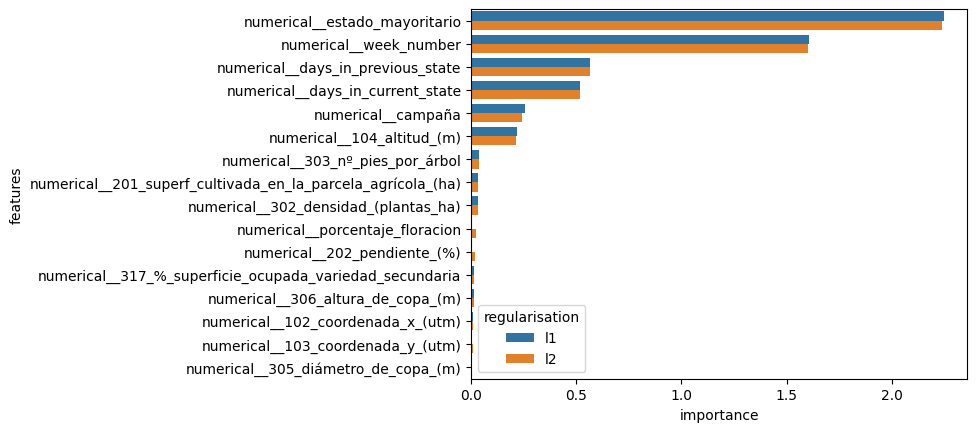

In [24]:
# Plot feature importance
lr_coeffs = pd.concat([best_model_lr_l2_coeff, best_model_lr_l1_coeff])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by=["importance"])
order_columns = best_model_lr_l2_coeff.sort_values(by="importance", ascending=False)[
    "features"
]
sns.barplot(
    data=lr_coeffs,
    x="importance",
    y="features",
    hue="regularisation",
    order=order_columns,
)

In [49]:
print(best_model_name_lr_l1)
print(best_model_name_lr_l2)

lr_l1_parcelas_numerical_c_1
lr_l2_parcelas_numerical_c_1


### Random Forest Trees

In [25]:
n_trees_grid = [5, 25, 50, 100, 250]

for n_trees in n_trees_grid:
    model_name = f"rf_parcelas_numerical_trees_{n_trees}"

    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train, y_train)

    evaluate_configuration(rf, model_name, X_train, y_train, X_test, y_test, models_metric_results)
    save_model(rf, model_name, models)

INFO:src.metrics:Computed Metrics for rf_parcelas_numerical_trees_5_train:
INFO:src.metrics:accuracy: 0.9792664344797563
INFO:src.metrics:mse: 0.025123349296183428
INFO:src.metrics:precision_for_class: [0.98757582 0.96969937 0.96975004 0.98003153]
INFO:src.metrics:recall_for_class: [0.9903138  0.9758758  0.9509758  0.90754258]
INFO:src.metrics:f1_for_class: [0.98894291 0.97277778 0.96027117 0.94239515]
INFO:src.metrics:confusion_matrix:
[[57152   541    17     1]
 [  658 36771   245     6]
 [   57   540 12182    31]
 [    4    68   118  1865]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for rf_parcelas_numerical_trees_5_test:
INFO:src.metrics:accuracy: 0.718070009460738
INFO:src.metrics:mse: 0.3626616209397666
INFO:src.metrics:precision_for_class: [0.85331553 0.61551155 0.49256827 0.40837696]
INFO:src.metrics:recall_for_class: [0.83605128 0.66143773 0.53231229 0.10803324]
INFO:src.metrics:f1_for_class: [0.84459519 0.63764876 0.51166966 0.170865

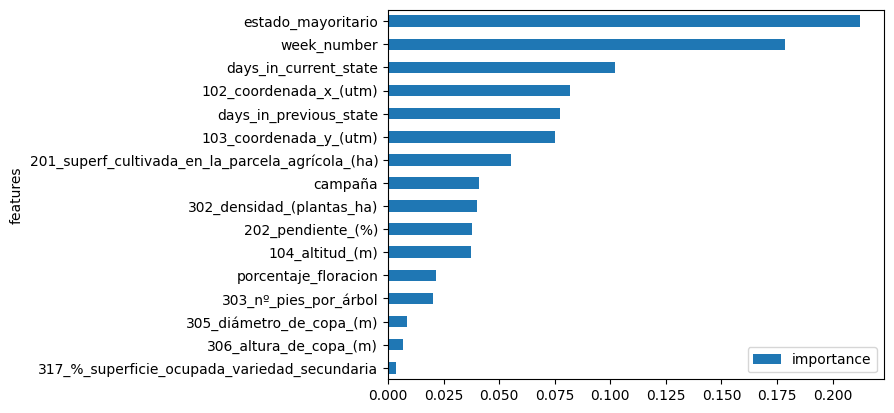

In [26]:
best_model_name_rf = max(
    models_metric_results,
    key=lambda x: models_metric_results[x]["test"]["accuracy"] if "rf" in x else 0,
)
best_model_rf = models[best_model_name_rf]

rf_fi, fig, ax = plot_feature_importance(
    best_model_rf, parcelas_numerical_cols + parcelas_created_features_cols
)

In [37]:
print(models_metric_results[best_model_name_rf]["test"])
print(best_model_name_rf)

{'accuracy': 0.7381177636617561, 'mse': 0.3079695454340677, 'precision_for_class': array([0.87536496, 0.64650503, 0.51275208, 0.43243243]), 'recall_for_class': array([0.83666172, 0.68380848, 0.64587225, 0.06648199]), 'f1_for_class': array([0.85557587, 0.66463374, 0.57166474, 0.1152461 ]), 'confusion_matrix': array([[9594, 1726,  140,    7],
       [1337, 5013,  949,   32],
       [  27,  897, 1729,   24],
       [   2,  118,  554,   48]])}
rf_parcelas_numerical_trees_250


### Lightgbm

In [52]:
evaluation_metrics = {}

In [57]:
import lightgbm as lgb

def evaluate_gbm_model(X_train, y_train, X_test, y_test):
    train_data = lgb.Dataset(X_train, label=np.array(y_train))
    test_data = lgb.Dataset(X_test, label=np.array(y_test), reference=train_data)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y_train)),
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, test_data],
        # early_stopping_rounds=10
    )

    evaluate_configuration(model, "lgb_with_selected_features", X_train, y_train, X_test, y_test, evaluation_metrics)
    lgb.plot_importance(model)
    plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 16
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.801081120301843
INFO:src.metrics:mse: 0.21817406762443767
INFO:src.metrics:precision_for_class: [0.89408231 0.71253556 0.65414875 0.87254902]
INFO:src.metrics:recall_for_class: [0.88199823 0.75788217 0.62958626 0.38978102]
INFO:src.metrics:f1_for_class: [0.88799916 0.73450963 0.64163252 0.53884965]
INFO:src.metrics:confusion_matrix:
[[50901  6632   176     2]
 [ 5898 28557  3201    24]
 [  127  4527  8065    91]
 [    5   362   887   801]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7488399333243231
INFO:src.metrics:mse: 0.28431770059016986
INFO:src.metrics:precision_for_class: [0.86893733 0.64709549 0.59349593 0.55059524]
INFO:src.metrics:recall_for_class: [0.83430714 0.70808894 0.62719462 0.25623269]
INFO:src.metrics:f1_for_class: [0.85127019 0.67621963 0.60988013 0.34971645]
IN

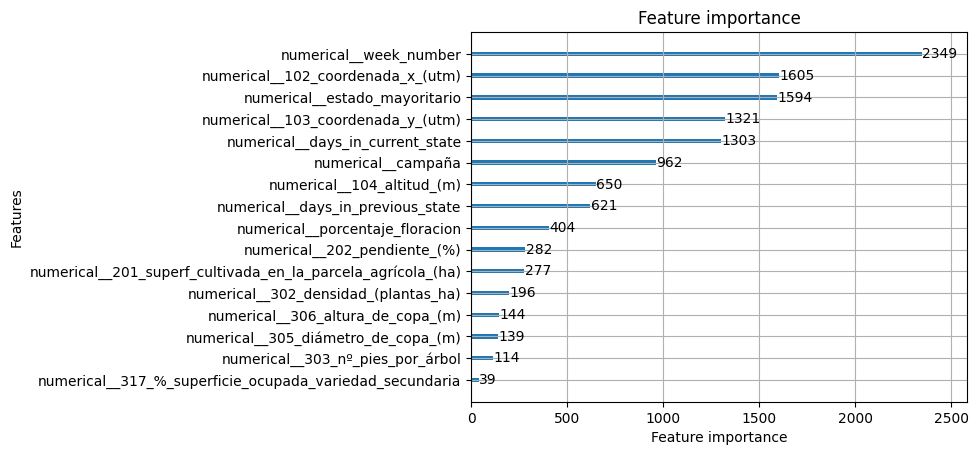

In [58]:
evaluate_gbm_model(X_train, y_train, X_test, y_test)

### XGBoost

In [32]:
n_trees_grid = [5, 25, 50, 100]

for lr in [0.05, 0.1]:
    for depth in [3, 5, 8]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train, y_train)
            model_name = f"gbt_parcelas_numerical_trees-{n_trees}_lr-{lr}_depth-{depth}"
            evaluate_configuration(
                gbt, model_name, X_train, y_train, X_test, y_test, models_metric_results
            )
            save_model(gbt, model_name, models)

INFO:src.metrics:Computed Metrics for gbt_parcelas_numerical_trees-5_lr-0.05_depth-3_train:
INFO:src.metrics:accuracy: 0.6029785227107822
INFO:src.metrics:mse: 0.6138985633434915
INFO:src.metrics:precision_for_class: [0.62795226 0.48565966 0.         0.        ]
INFO:src.metrics:recall_for_class: [0.98913552 0.24941614 0.         0.        ]
INFO:src.metrics:f1_for_class: [0.768208   0.32957514 0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57084   627     0     0]
 [28282  9398     0     0]
 [ 4974  7836     0     0]
 [  565  1490     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for gbt_parcelas_numerical_trees-5_lr-0.05_depth-3_test:
INFO:src.metrics:accuracy: 0.5785466504482588
INFO:src.metrics:mse: 0.6942379600846962
INFO:src.metrics:precision_for_class: [0.61593656 0.38923791 0.         0.        ]
INFO:src.metrics:recall_for_class: [0.99563966 0.19438003 0.         0.        ]
INFO:src.metrics:f1_for_class: [0.761057

{'accuracy': 0.7533900977609587, 'mse': 0.27683921250619453, 'precision_for_class': array([0.87993768, 0.66745098, 0.55361446, 0.56329114]), 'recall_for_class': array([0.83727217, 0.69649434, 0.68658947, 0.2465374 ]), 'f1_for_class': array([0.85807489, 0.68166344, 0.61297315, 0.34296724]), 'confusion_matrix': array([[9601, 1768,   86,   12],
       [1289, 5106,  909,   27],
       [  20,  720, 1838,   99],
       [   1,   56,  487,  178]])}


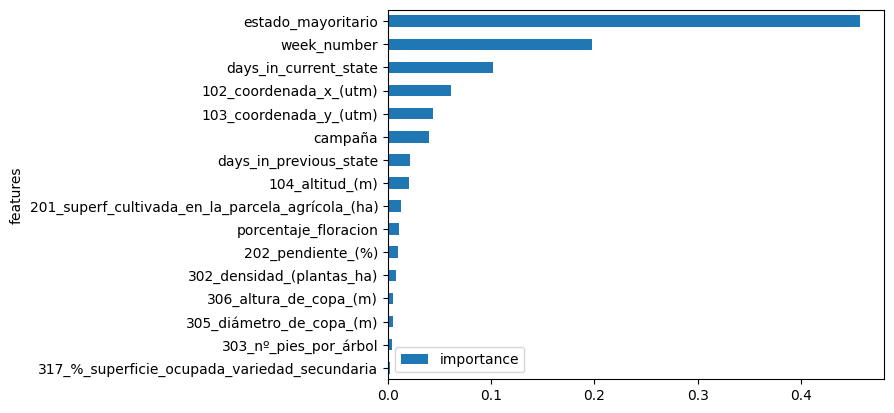

In [35]:
best_model_name_gbt = max(
    models_metric_results,
    key=lambda x: models_metric_results[x]["test"]["accuracy"] if "gbt" in x else 0,
)
best_model_gbt = models[best_model_name_gbt]

rf_fi, fig, ax = plot_feature_importance(
    best_model_gbt, parcelas_numerical_cols + parcelas_created_features_cols
)
print(models_metric_results[best_model_name_gbt]["test"])

In [36]:
best_model_name_gbt

'gbt_parcelas_numerical_trees-100_lr-0.05_depth-8'

Insights:
- The most predictive parcelas features are: ['estado_mayoritario',
 'week_number',
 'days_in_current_state',
 'campaña',
 '102_coordenada_x_(utm)',
 '103_coordenada_y_(utm)']

## Retraining with selected features

In [39]:
# Include imputation with LOCF for meteo cols
def preprocess_data(columns_parcela: list[str], columns_meteo: list[str]):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"
    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )


    # LOCF for weather indices
    feature_frame["fecha"] = pd.to_datetime(feature_frame["fecha"])
    feature_frame.sort_values(by=["codparcela", "fecha"], inplace=True)
    feature_frame.set_index("fecha", inplace=True)
    feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
    feature_frame.reset_index(inplace=True)

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)


    numerical_processor = Pipeline(
        steps=[
            ("imputation_mean", SimpleImputer(strategy="mean")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("parcelas", numerical_processor, columns_parcela + columns_meteo),
        ]
    )


    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    # Use get_feature_names_out to get the transformed column names
    transformed_names = preprocessor.get_feature_names_out()

    # Create DataFrames with the transformed names
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=transformed_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_names)

    return X_train_preprocessed, y_train.array, X_test_preprocessed, y_test.array

In [40]:
selected_parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

parcelas_cols = selected_parcelas_cols

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=[]
)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


#### Random Forest Trees

In [41]:
n_trees = 250
model_name = f"rf_selected_parcelas_trees_{n_trees}"

rf = RandomForestClassifier(n_trees)
rf.fit(X_train, y_train)

evaluate_configuration(rf, model_name, X_train, y_train, X_test, y_test, models_metric_results)
save_model(rf, model_name, models)

INFO:src.metrics:Computed Metrics for rf_selected_parcelas_trees_250_train:
INFO:src.metrics:accuracy: 0.9995011609345523
INFO:src.metrics:mse: 0.0005260484690175592
INFO:src.metrics:precision_for_class: [0.99982672 0.99938947 0.99828366 1.        ]
INFO:src.metrics:recall_for_class: [0.99982672 0.99917728 0.9989071  1.        ]
INFO:src.metrics:f1_for_class: [0.99982672 0.99928336 0.99859529 1.        ]
INFO:src.metrics:confusion_matrix:
[[57701    10     0     0]
 [    9 37649    22     0]
 [    1    13 12796     0]
 [    0     0     0  2055]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for rf_selected_parcelas_trees_250_test:
INFO:src.metrics:accuracy: 0.7247375771500654
INFO:src.metrics:mse: 0.33202685047528946
INFO:src.metrics:precision_for_class: [0.87671487 0.64582767 0.48086386 0.30025445]
INFO:src.metrics:recall_for_class: [0.8248016  0.64820625 0.65707882 0.1634349 ]
INFO:src.metrics:f1_for_class: [0.8499663  0.64701477 0.55532755 0.2

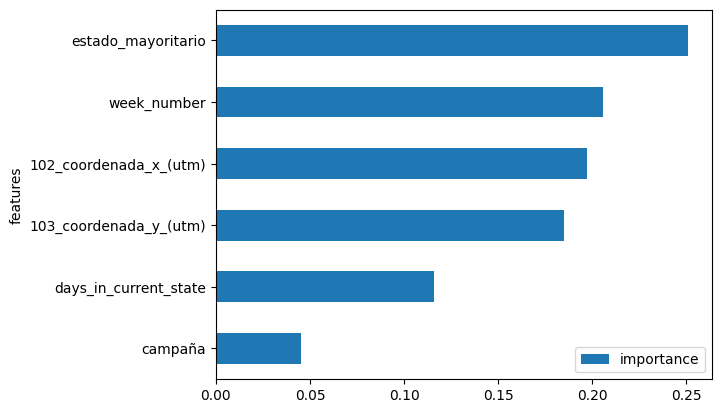

In [43]:
best_model_rf = rf

rf_fi, fig, ax = plot_feature_importance(
    best_model_rf, parcelas_cols
)

#### XGBoost

INFO:src.metrics:Computed Metrics for gbt_selected_parcelas_train:
INFO:src.metrics:accuracy: 0.8558899288927587
INFO:src.metrics:mse: 0.15615476708750545
INFO:src.metrics:precision_for_class: [0.92329878 0.78935162 0.74977981 0.91603631]
INFO:src.metrics:recall_for_class: [0.91526745 0.82194798 0.73099141 0.5892944 ]
INFO:src.metrics:f1_for_class: [0.91926558 0.80532009 0.74026641 0.71720462]
INFO:src.metrics:confusion_matrix:
[[52821  4787   103     0]
 [ 4291 30971  2398    20]
 [   93  3262  9364    91]
 [    4   216   624  1211]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for gbt_selected_parcelas_test:
INFO:src.metrics:accuracy: 0.739604451051944
INFO:src.metrics:mse: 0.3011668243456323
INFO:src.metrics:precision_for_class: [0.88070665 0.65519075 0.52684758 0.41978022]
INFO:src.metrics:recall_for_class: [0.8260225  0.67235029 0.68173328 0.26454294]
INFO:src.metrics:f1_for_class: [0.85248852 0.66365962 0.59436574 0.32455395]
INFO:src.metr

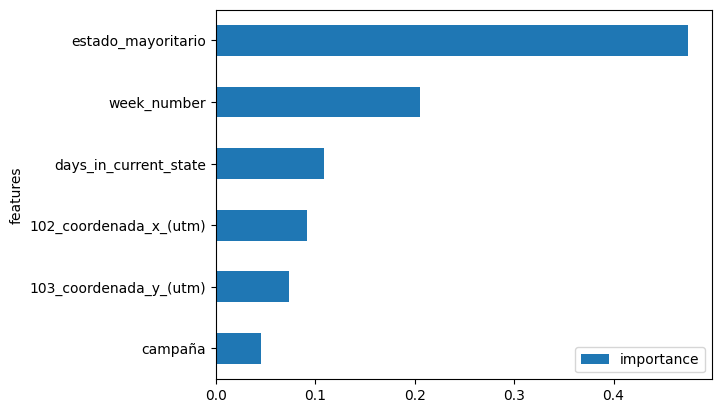

In [44]:
best_lr = 0.05
best_depth = 8
best_n_trees = 100
gbt = GradientBoostingClassifier(
    learning_rate=best_lr, max_depth=best_depth, n_estimators=best_n_trees
)
gbt.fit(X_train, y_train)
evaluate_configuration(
    gbt,
    "gbt_selected_parcelas",
    X_train,
    y_train,
    X_test,
    y_test,
    models_metric_results,
)
gbt_fi, fig, ax = plot_feature_importance(gbt, parcelas_cols)

Insights:
- Only using these selected features improves all the model's performance.

## Introducing Meteo Features

In [45]:
def preprocess_data(columns_parcela: list[str], columns_meteo: list[str]):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"
    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )


    # LOCF for weather indices
    feature_frame["fecha"] = pd.to_datetime(feature_frame["fecha"])
    feature_frame.sort_values(by=["codparcela", "fecha"], inplace=True)
    feature_frame.set_index("fecha", inplace=True)
    feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
    feature_frame.reset_index(inplace=True)

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)


    numerical_processor = Pipeline(
        steps=[
            ("imputation_mean", SimpleImputer(strategy="mean")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("parcelas", numerical_processor, columns_parcela + columns_meteo),
        ]
    )


    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    # Use get_feature_names_out to get the transformed column names
    transformed_names = preprocessor.get_feature_names_out()

    # Create DataFrames with the transformed names
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=transformed_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_names)

    return X_train_preprocessed, y_train.array, X_test_preprocessed, y_test.array

In [47]:
METEO_COLUMNS = ["FAPAR", "GNDVI", "LST", "NDVI", "NDWI", "SAVI", "SIPI", "SSM"]
DAYS = ["365D", "90D"]
STATS = ["count", "mean", "std", "min", "median", "max"]
selected_meteo_cols = [f"{col}_{stat}_{day}" for col in METEO_COLUMNS for day in DAYS for stat in STATS]

selected_parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]
parcelas_cols = selected_parcelas_cols

#### Lasso

In [73]:
def linear_models_feature_importance(lr: Pipeline, X_train: pd.DataFrame, reg_type: str = "l1"):

    # best_model_name_lr_l1 = max(
    #     models_metric_results,
    #     key=lambda x: models_metric_results[x]["test"]["accuracy"] if "l1" in x else 0,
    # )
    # best_model_lr_l1 = models[best_model_name_lr_l1]

    plt.figure(figsize=(14, 16))
    lr_coeff = pd.DataFrame(
        {
            "features": X_train.columns,
            "importance": np.abs(lr.named_steps["lr"].coef_[0]),
            "regularisation": [reg_type] * len(X_train.columns),
        }
    )
    lr_coeff = lr_coeff.sort_values(
        "importance", ascending=True
    )

    # Plot feature importance
    lr_coeffs = pd.concat([lr_coeff])
    lr_coeffs["features"] = pd.Categorical(lr_coeff["features"])
    lr_coeffs = lr_coeffs.sort_values(by=["importance"])
    order_columns = lr_coeff.sort_values(by="importance", ascending=False)[
        "features"
    ]
    sns.barplot(
        data=lr_coeffs,
        x="importance",
        y="features",
        hue="regularisation",
        order=order_columns,
    )

In [52]:
selected_meteo_cols = [
    f"{col}_{stat}_{day}" for col in METEO_COLUMNS for day in DAYS for stat in STATS
]
for col in METEO_COLUMNS:
    selected_meteo_cols.append(col)

meteo_cols = selected_meteo_cols

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

UnboundLocalError: cannot access local variable 'lr_coeffs' where it is not associated with a value

INFO:src.metrics:Computed Metrics for lr_l1_c-1e-08_selected_parcelas_and_meteo_LOCF_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_l1_c-1e-08_selected_parcelas_and_meteo_LOCF_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matr

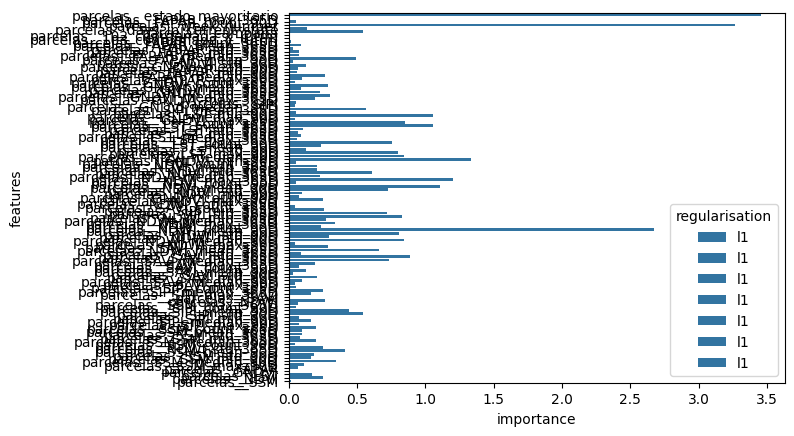

In [54]:
from sklearn.linear_model import LogisticRegression

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]

for c in cs:
    model_name = f"lr_l1_c-{c}_selected_parcelas_and_meteo_LOCF"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l1", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, models_metric_results)
    save_model(lr, model_name, models)
    linear_models_feature_importance(lr, X_train, reg_type="l1")

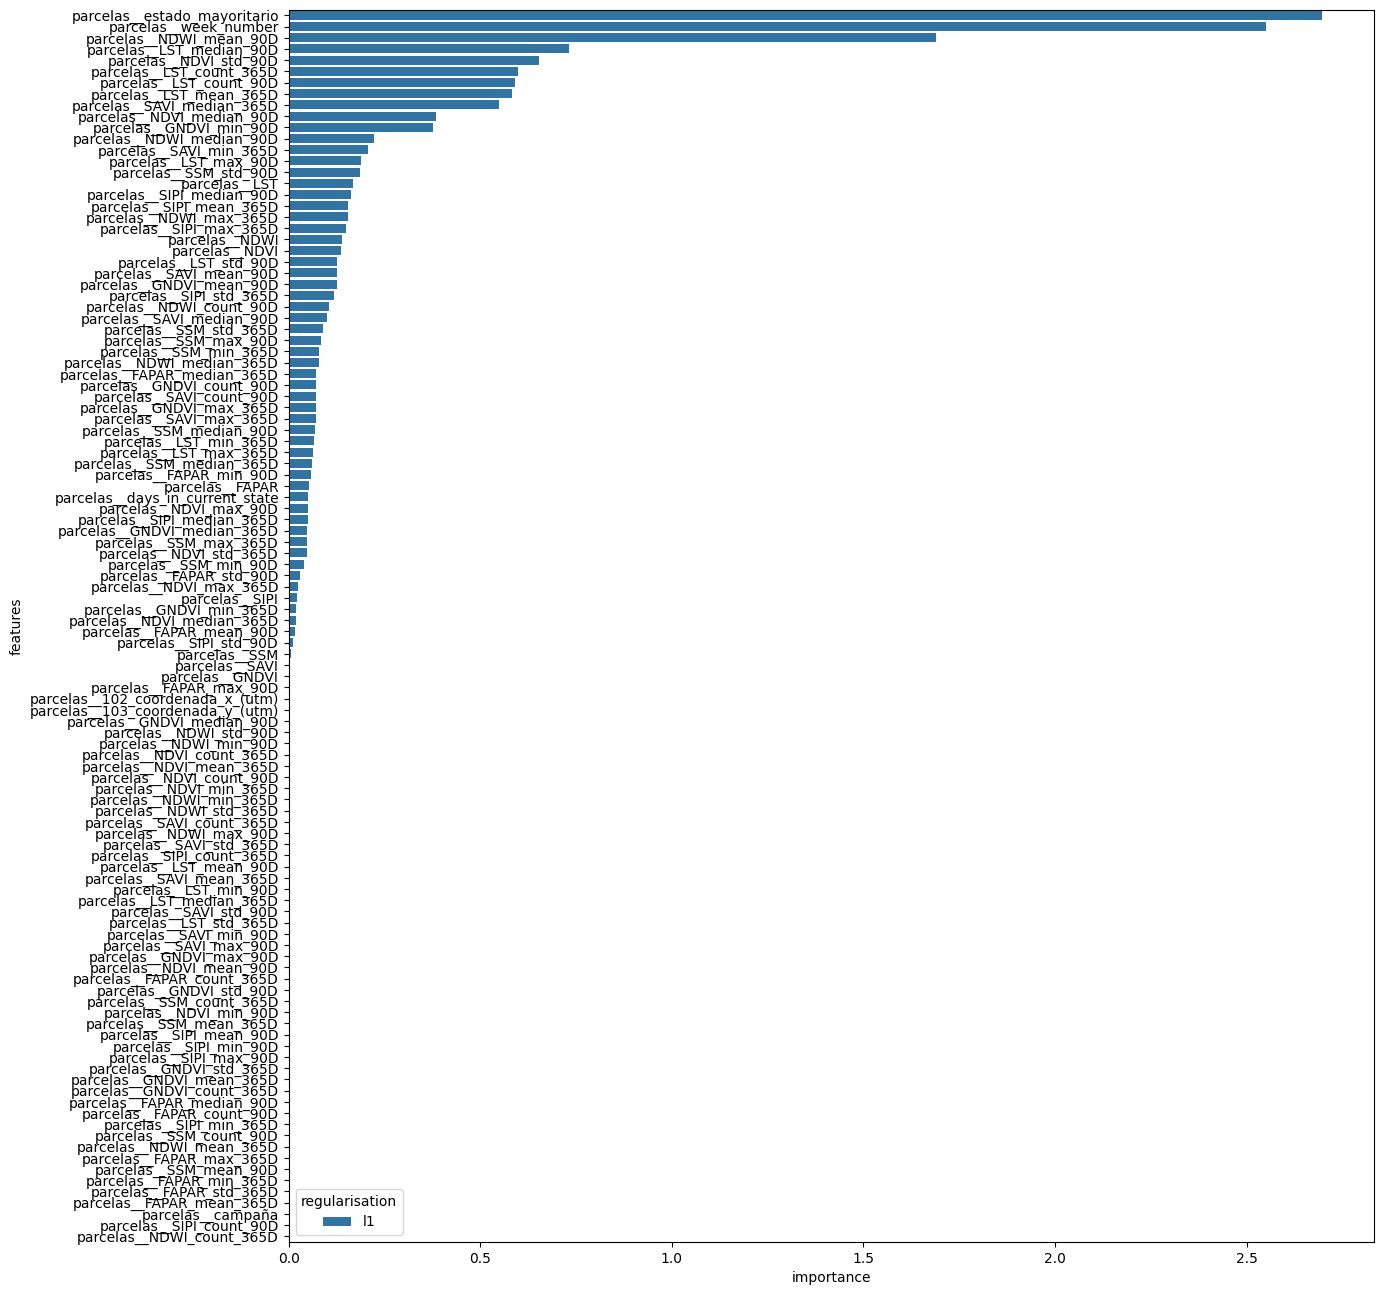

In [74]:
lr = models["lr_l1_c-0.01_selected_parcelas_and_meteo_LOCF"]
linear_models_feature_importance(lr, X_train, reg_type="l1")

As the models perform poor, we will not consider their feature importance.

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
INFO:src.metrics:Computed Metrics for gbt_selected_parcelas_and_FAPAR_LOCF_train:
INFO:src.metrics:accuracy: 0.8647601944565375
INFO:src.metrics:mse: 0.14658612683209984
INFO:src.metrics:precision_for_class: [0.92675554 0.80059205 0.77186799 0.9578

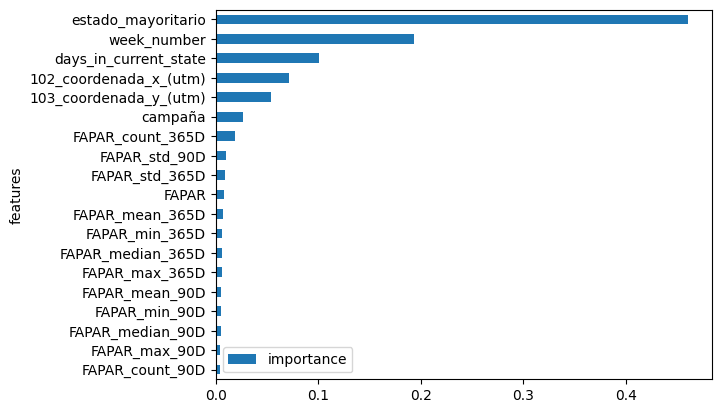

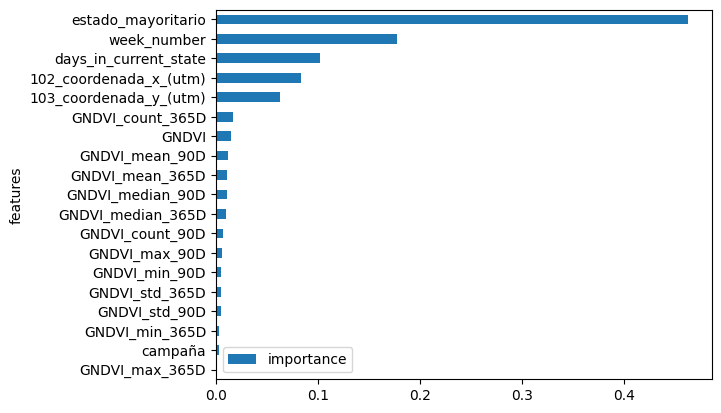

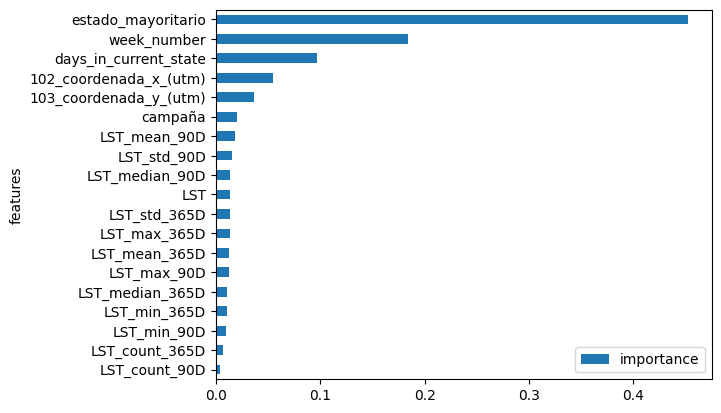

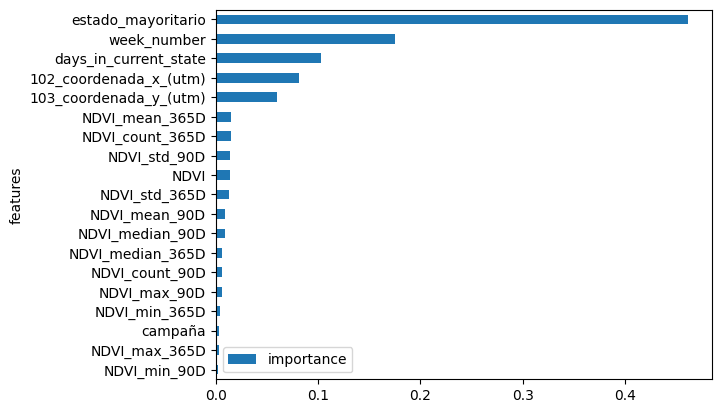

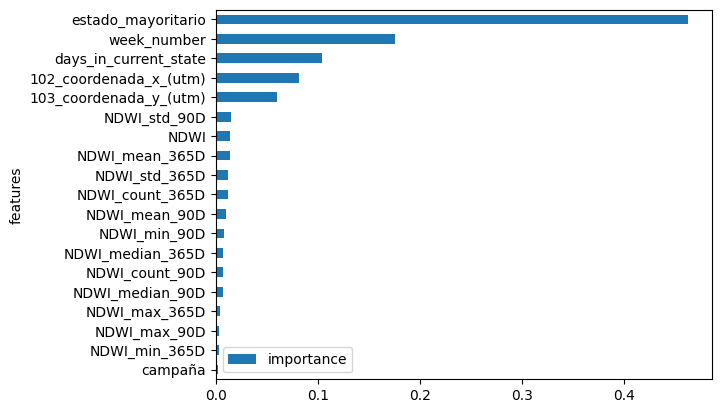

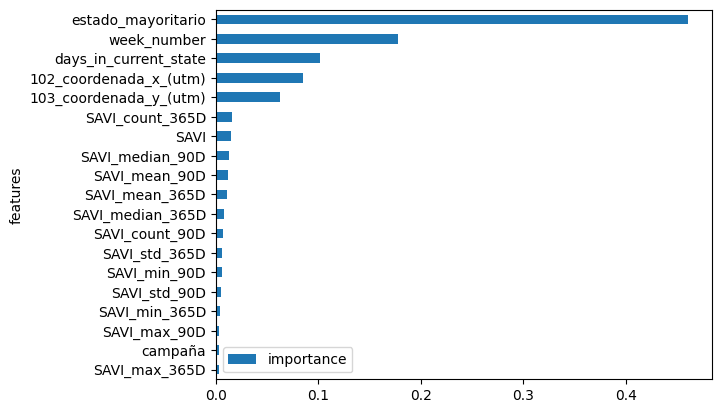

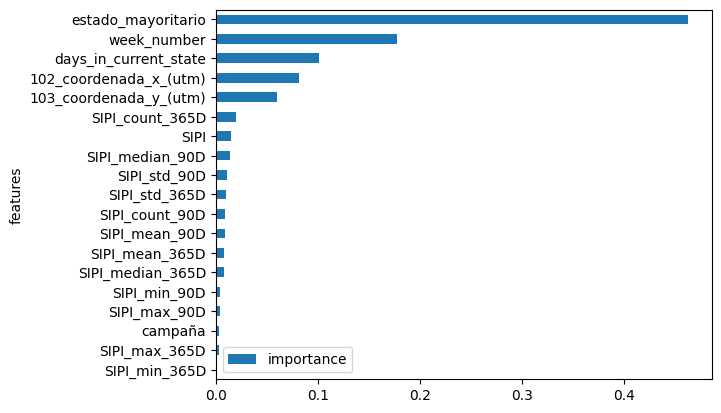

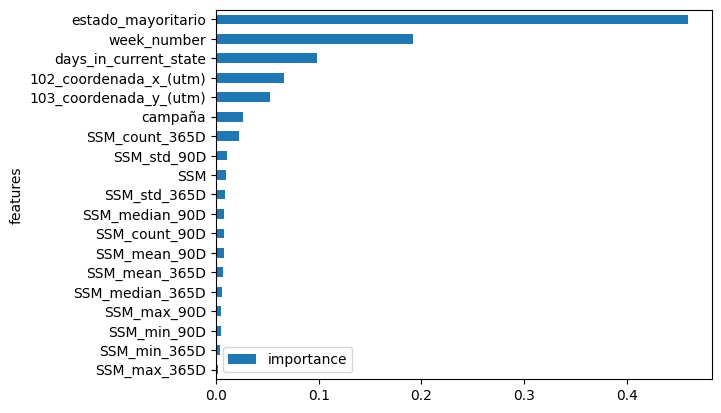

In [48]:
for col in METEO_COLUMNS:
    selected_meteo_cols = [
        f"{col}_{stat}_{day}" for day in DAYS for stat in STATS
    ]
    selected_meteo_cols.append(col)

    meteo_cols = selected_meteo_cols

    X_train, y_train, X_test, y_test = preprocess_data(
        columns_parcela=parcelas_cols, columns_meteo=meteo_cols
    )

    best_lr = 0.05
    best_depth = 8
    best_n_trees = 100

    model_name = f"gbt_selected_parcelas_and_{col}_LOCF"

    gbt = GradientBoostingClassifier(
        learning_rate=best_lr, max_depth=best_depth, n_estimators=best_n_trees
    )
    gbt.fit(X_train, y_train)

    evaluate_configuration(
        gbt,
        model_name,
        X_train,
        y_train,
        X_test,
        y_test,
        models_metric_results,
    )
    gbt_fi, fig, ax = plot_feature_importance(gbt, parcelas_cols + meteo_cols)
    save_model(gbt, model_name, models)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_47983/2551414947.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

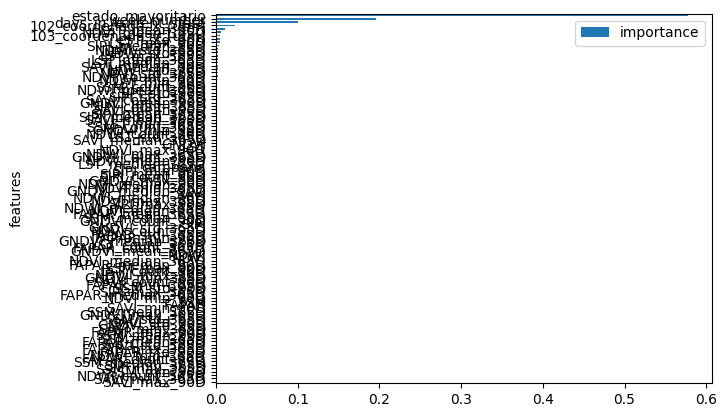

In [75]:
selected_meteo_cols = [
    f"{col}_{stat}_{day}" for col in METEO_COLUMNS for day in DAYS for stat in STATS
]
for col in METEO_COLUMNS:
    selected_meteo_cols.append(col)

meteo_cols = selected_meteo_cols

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

best_lr = 0.05
best_depth = 5
best_n_trees = 50

model_name = f"gbt_selected_parcelas_and_meteo_LOCF_lr-{best_lr}_d-{best_depth}_n-{best_n_trees}"

gbt = GradientBoostingClassifier(
    learning_rate=best_lr, max_depth=best_depth, n_estimators=best_n_trees
)
gbt.fit(X_train, y_train)

evaluate_configuration(
    gbt,
    model_name,
    X_train,
    y_train,
    X_test,
    y_test,
    models_metric_results,
)
gbt_fi, fig, ax = plot_feature_importance(gbt, parcelas_cols + meteo_cols)
save_model(gbt, model_name, models)

In [ ]:
# LST, SIPI, SAVI, FAPAR 
# LST = "mean_90D", "median_365D", "mean_365D", "std_365D"
# SIPI = "count_365D"
# SAVI = "count mean 365D"
# FAPAR = "count mean 365D"
# SIPI, SAVI
selected_features_parcelas = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
]
parcelas_cols = selected_features_parcelas

selected_meteo_cols = [f"LST_{stat}" for stat in ["mean_90D", "median_365D", "count_365D", "mean_365D"]]
meteo_cols = selected_meteo_cols

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

best_lr = 0.05
best_depth = 3
best_n_trees = 25
gbt = GradientBoostingClassifier(
    learning_rate=best_lr, max_depth=best_depth, n_estimators=best_n_trees
)
gbt.fit(X_train, y_train)
evaluate_configuration(gbt, f"gbt_with_best_features", X_train, y_train, X_test, y_test, evaluation_metrics)

## Selecting Features: Features importance

In [15]:
### I won't use columns with more than 80% of nulls
label_col = 'target'

PHENOLOGICAL_STATE_COLS = [f"estado_fenologico_{i}" for i in range(14, 0, -1)]

parcelas_numerical_cols = ['campaña','porcentaje_floracion','102_coordenada_x_(utm)',
        '103_coordenada_y_(utm)', '104_altitud_(m)','201_superf_cultivada_en_la_parcela_agrícola_(ha)',
        '202_pendiente_(%)', '302_densidad_(plantas_ha)', '303_nº_pies_por_árbol',
        '305_diámetro_de_copa_(m)','317_%_superficie_ocupada_variedad_secundaria',
        '306_altura_de_copa_(m)', 'estado_mayoritario']

parcelas_categorical_cols = ['codparcela', '105_comarca', '203_orientación', '204_textura_del_suelo',
       '206_secano_/_regadío', '211_utilización_de_cubierta_vegetal',
       '212_tipo_de_cubierta_vegetal',
       '214_cultivo_asociado/otro_aprovechamiento', '301_marco_(m_x_m)',
       '304_formación', '308_variedad_principal',
       '311_fecha_de_plantación_variedad_principal',
       '208_riego:_procedencia_del_agua', '209_riego:_calidad_del_agua',
       '313_variedad_secundaria', '107_zona_homogénea',
       '120_zona_biológica_raif', '401_estación_climática_asociada',
       '402_sensor_climático_asociado', '207_riego:_sistema_usual_de_riego',
       '108_u_h_c_a_la_que_pertenece',
       '316_fecha_de_plantación_variedad_secundaria',
       '315_patrón_variedad_secundaria', '310_patrón_variedad_principal',
       '411_representa_a_la_u_h_c_(si/no)',
       '109_sistema_para_el_cumplimiento_gestión_integrada']

parcelas_created_features_cols = ['week_number', 'days_in_current_state', 'days_in_previous_state']


# meteo_numerical_cols = ['lat', 'lon', 'FAPAR', 'GNDVI', 'LST',
#                          'NDVI', 'NDWI', 'SAVI', 'SIPI', 'SSM']


METEO_COLUMNS = ["FAPAR", "GNDVI", "LST", "NDVI", "NDWI", "SAVI", "SIPI", "SSM"]
DAYS = ["365D", "90D"]
STATS = ["count", "mean", "std", "min", "median", "max"]
meteo_stats_cols = [f"{col}_{stat}_{day}" for col in METEO_COLUMNS for day in DAYS for stat in STATS]

selected_parcelas_cols = parcelas_numerical_cols + parcelas_created_features_cols
selected_meteo_cols = meteo_stats_cols

In [16]:
def preprocess_data(columns_parcela: list[str], columns_meteo: list[str]):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"

    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )

    # LOCF for weather indices
    feature_frame["fecha"] = pd.to_datetime(feature_frame["fecha"])
    feature_frame.sort_values(by=["codparcela", "fecha"], inplace=True)
    feature_frame.set_index("fecha", inplace=True)
    feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
    feature_frame.reset_index(inplace=True)

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)


    numerical_processor = Pipeline(
        steps=[
            ("imputation_mean", SimpleImputer(strategy="mean")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("impute", numerical_processor, columns_parcela + columns_meteo),
        ]
    )


    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    # Use get_feature_names_out to get the transformed column names
    transformed_names = preprocessor.get_feature_names_out()

    # Create DataFrames with the transformed names
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=transformed_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_names)

    return X_train_preprocessed, y_train.array, X_test_preprocessed, y_test.array

In [17]:
X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_18065/3627457574.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_18065/3627457574.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_18065/3627457574.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [14]:
X_train.columns

Index(['impute__campaña', 'impute__porcentaje_floracion',
       'impute__102_coordenada_x_(utm)', 'impute__103_coordenada_y_(utm)',
       'impute__104_altitud_(m)',
       'impute__201_superf_cultivada_en_la_parcela_agrícola_(ha)',
       'impute__202_pendiente_(%)', 'impute__302_densidad_(plantas_ha)',
       'impute__303_nº_pies_por_árbol', 'impute__305_diámetro_de_copa_(m)',
       'impute__317_%_superficie_ocupada_variedad_secundaria',
       'impute__306_altura_de_copa_(m)', 'impute__estado_mayoritario',
       'impute__week_number', 'impute__days_in_current_state',
       'impute__days_in_previous_state', 'impute__LST_count_365D',
       'impute__LST_mean_365D', 'impute__LST_std_365D',
       'impute__LST_median_365D', 'impute__LST_count_90D',
       'impute__LST_mean_90D', 'impute__LST_std_90D', 'impute__LST_median_90D',
       'impute__SSM_count_365D', 'impute__SSM_mean_365D',
       'impute__SSM_std_365D', 'impute__SSM_median_365D',
       'impute__SSM_count_90D', 'impute__S

## Selected features

In [6]:
selected_features_parcelas = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
]

METEO_COLUMNS = ["FAPAR", "GNDVI", "LST", "NDVI", "NDWI", "SAVI", "SIPI", "SSM"]
SELECTED_METEO_COLS = ["LST", "SSM"]
SELECTED_DAYS = ["365D", "90D"]
SELECTED_STATS = ["count", "mean", "std", "median"]

selected_meteo_cols = [
    f"{col}_{stat}_{day}" for col in SELECTED_METEO_COLS for day in SELECTED_DAYS for stat in SELECTED_STATS
]
for col in SELECTED_METEO_COLS:
    selected_meteo_cols.append(col)

parcelas_cols = selected_features_parcelas
meteo_cols = selected_meteo_cols

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


In [8]:
evaluation_metrics = {}

### Logistic regression with selected features

In [9]:
from sklearn.linear_model import LogisticRegression

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    model_name = f"lr_ridge_with_selected_features_c_{c}"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l2", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)

INFO:src.metrics:Computed Metrics for lr_ridge_with_selected_features_c_1e-08_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_ridge_with_selected_features_c_1e-08_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[11467   

In [10]:
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    model_name = f"lr_lasso_with_selected_features_c_{c}"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l1", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)

INFO:src.metrics:Computed Metrics for lr_lasso_with_selected_features_c_1e-08_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_lasso_with_selected_features_c_1e-08_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[11467   

### Random Forest Trees with selected features

In [11]:
n_trees_grid = [5, 25, 50, 100, 250]

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train, y_train)

    model_name = f"rf_with_selected_features_trees-{n_trees}"

    evaluate_configuration(rf, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)

INFO:src.metrics:Computed Metrics for rf_with_selected_features_trees-5_train:
INFO:src.metrics:accuracy: 0.9724459439849078
INFO:src.metrics:mse: 0.03421129008852126
INFO:src.metrics:precision_for_class: [0.98119047 0.96215145 0.96160334 0.98121547]
INFO:src.metrics:recall_for_class: [0.98885828 0.96610934 0.93450429 0.86423358]
INFO:src.metrics:f1_for_class: [0.98500945 0.96412633 0.94786017 0.91901682]
INFO:src.metrics:confusion_matrix:
[[57068   619    23     1]
 [  991 36403   283     3]
 [   94   715 11971    30]
 [    9    98   172  1776]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for rf_with_selected_features_trees-5_test:
INFO:src.metrics:accuracy: 0.6791458305176375
INFO:src.metrics:mse: 0.43496868946253997
INFO:src.metrics:precision_for_class: [0.77337699 0.57061765 0.53085211 0.36051502]
INFO:src.metrics:recall_for_class: [0.84459754 0.57591052 0.40493089 0.11634349]
INFO:src.metrics:f1_for_class: [0.80741976 0.57325187 0.45941937

### XGBoost with selected features

In [12]:
n_trees_grid = [5, 25, 50, 100]

for lr in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train, y_train)
            model_name = f"gbt_with_selected_features_trees-{n_trees}_lr-{lr}_depth-{depth}"
            evaluate_configuration(
                rf, model_name, X_train, y_train, X_test, y_test, evaluation_metrics
            )

INFO:src.metrics:Computed Metrics for gbt_with_selected_features_trees-5_lr-0.05_depth-1_train:
INFO:src.metrics:accuracy: 0.9981769699608185
INFO:src.metrics:mse: 0.002086054273690321
INFO:src.metrics:precision_for_class: [0.99849338 0.99782245 0.99765662 0.99902534]
INFO:src.metrics:recall_for_class: [0.99908163 0.99721338 0.99703357 0.99756691]
INFO:src.metrics:f1_for_class: [0.99878742 0.99751782 0.99734499 0.99829559]
INFO:src.metrics:confusion_matrix:
[[57658    52     1     0]
 [   80 37575    25     0]
 [    6    30 12772     2]
 [    1     0     4  2050]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for gbt_with_selected_features_trees-5_lr-0.05_depth-1_test:
INFO:src.metrics:accuracy: 0.7349191332162004
INFO:src.metrics:mse: 0.2991395233590125
INFO:src.metrics:precision_for_class: [0.84099983 0.6365472  0.57411504 0.56410256]
INFO:src.metrics:recall_for_class: [0.84503357 0.6880371  0.58162122 0.03047091]
INFO:src.metrics:f1_for_class:

KeyboardInterrupt: 

### LightGBM

In [5]:
import lightgbm as lgb

In [28]:
def evaluate_configuration(
    model: Pipeline,
    model_name: str,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    evaluation_metrics: dict,
) -> None:
    y_train_pred_prob = model.predict(X_train, num_iteration=model.best_iteration)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)

    y_test_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    evaluation_metrics[model_name] = {
        "train": evaluate_classification(y_train, y_train_pred),
        "test": evaluate_classification(y_test, y_test_pred),
    }
    log_metrics(model_name + "_train", evaluation_metrics[model_name]["train"])
    log_metrics(model_name + "_test", evaluation_metrics[model_name]["test"])

def evaluate_gbm_model(X_train, y_train, X_test, y_test, evaluation_metrics: dict):
    train_data = lgb.Dataset(X_train, label=np.array(y_train))
    test_data = lgb.Dataset(X_test, label=np.array(y_test), reference=train_data)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y_train)),
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, test_data],
        # early_stopping_rounds=10
    )

    evaluate_configuration(model, "lgb_with_selected_features", X_train, y_train, X_test, y_test, evaluation_metrics)
    lgb.plot_importance(model)
    plt.show()
    return model

In [20]:
evaluate_gbm_model(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3858
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 21
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.7861794369467421
INFO:src.metrics:mse: 0.23703925409955015
INFO:src.metrics:precision_for_class: [0.88140396 0.69622269 0.62706485 0.82623318]
INFO:src.metrics:recall_for_class: [0.87853269 0.7308121  0.60156128 0.35863747]
INFO:src.metrics:f1_for_class: [0.87996598 0.7130982  0.61404837 0.50016966]
INFO:src.metrics:confusion_matrix:
[[50701  6783   227     0]
 [ 6652 27537  3457    34]
 [  165  4818  7706   121]
 [    5   414   899   737]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7409109339099879
INFO:src.metrics:mse: 0.29544533045006083
INFO:src.metrics:precision_for_class: [0.84114088 0.63849765 0.62456747 0.5483871 ]
INFO:src.metrics:recall_for_class: [0.84869626 0.68640022 0.53940979 0.32963989]
INFO:src.metrics:f1_for_class: [0.84490168 0.66158296 0.57887352 0.41176471]
I

## Selecting the best features

As lightgbm seems to perform well, we will only use this model onwards to\
refine further the features to use.

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4373
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 24
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.8010357712958932
INFO:src.metrics:mse: 0.21882709331011463
INFO:src.metrics:precision_for_class: [0.89538618 0.71450878 0.64206583 0.85406464]
INFO:src.metrics:recall_for_class: [0.88406023 0.75294586 0.62888368 0.4243309 ]
INFO:src.metrics:f1_for_class: [0.88968716 0.73322393 0.6354064  0.56697009]
INFO:src.metrics:confusion_matrix:
[[51020  6487   203     1]
 [ 5822 28371  3466    21]
 [  134  4493  8056   127]
 [    5   356   822   872]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7451006892823354
INFO:src.metrics:mse: 0.2862548993107177
INFO:src.metrics:precision_for_class: [0.8644915  0.63675572 0.60257913 0.59027778]
INFO:src.metrics:recall_for_class: [0.82951077 0.72500341 0.57601793 0.23545706]
INFO:src.metrics:f1_for_class: [0.84663996 0.67802016 0.58899924 0.33663366]
IN

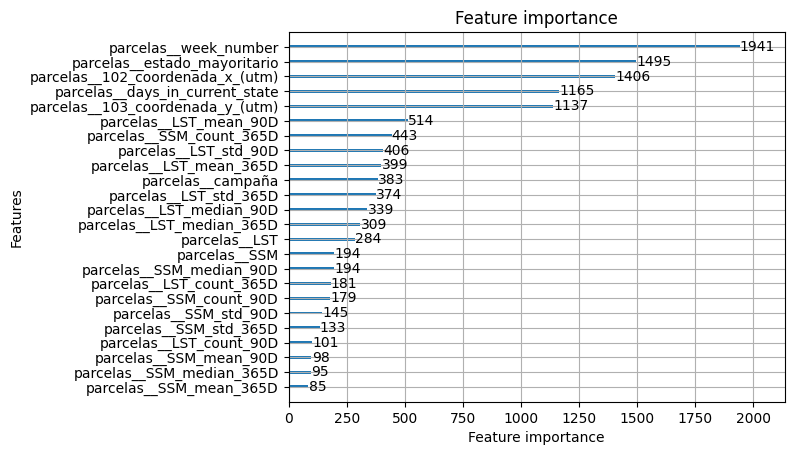

In [38]:
parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

# METEO_COLUMNS = ["FAPAR", "GNDVI", "LST", "NDVI", "NDWI", "SAVI", "SIPI", "SSM"]
SELECTED_METEO_COLS = ["LST", "SSM"]
SELECTED_DAYS = ["365D", "90D"]
SELECTED_STATS = ["count", "mean", "std", "median"]

meteo_cols = [
    f"{col}_{stat}_{day}" for col in SELECTED_METEO_COLS for day in SELECTED_DAYS for stat in SELECTED_STATS
]

for col in SELECTED_METEO_COLS:
    meteo_cols.append(col)

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

evaluate_gbm_model(X_train, y_train, X_test, y_test)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 11
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.7998476273400087
INFO:src.metrics:mse: 0.21893593092439415
INFO:src.metrics:precision_for_class: [0.8971479  0.71333467 0.63662542 0.83196721]
INFO:src.metrics:recall_for_class: [0.88026546 0.7535828  0.63856362 0.39513382]
INFO:src.metrics:f1_for_class: [0.8886265  0.73290659 0.63759305 0.53579677]
INFO:src.metrics:confusion_matrix:
[[50801  6707   202     1]
 [ 5701 28395  3555    29]
 [  119  4377  8180   134]
 [    4   327   912   812]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7469928368698473
INFO:src.metrics:mse: 0.2783709510294184
INFO:src.metrics:precision_for_class: [0.86721311 0.64036254 0.59139389 0.68161435]
INFO:src.metrics:recall_for_class: [0.83038284 0.7228209  0.60067239 0.21052632]
INFO:src.metrics:f1_for_class: [0.84839845 0.67909778 0.59599703 0.32169312]
IN

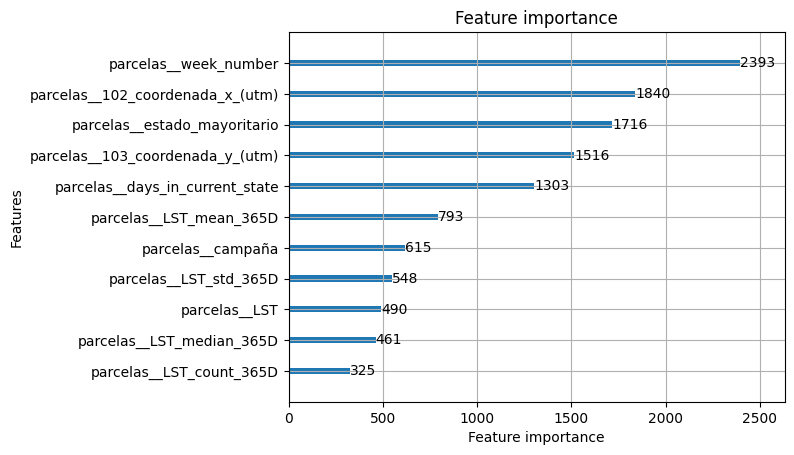

In [39]:
parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

SELECTED_METEO_COLS = ["LST"]
SELECTED_DAYS = ["365D"]
SELECTED_STATS = ["count", "mean", "std", "median"]

meteo_cols = [
    f"{col}_{stat}_{day}"
    for col in SELECTED_METEO_COLS
    for day in SELECTED_DAYS
    for stat in SELECTED_STATS
]

for col in SELECTED_METEO_COLS:
    meteo_cols.append(col)

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

evaluate_gbm_model(X_train, y_train, X_test, y_test)

In [11]:
parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

SELECTED_METEO_COLS = ["LST"]
SELECTED_DAYS = ["365D"]
SELECTED_STATS = ["mean", "std", "median"]

meteo_cols = [
    f"{col}_{stat}_{day}"
    for col in SELECTED_METEO_COLS
    for day in SELECTED_DAYS
    for stat in SELECTED_STATS
]

for col in SELECTED_METEO_COLS:
    meteo_cols.append(col)

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_79538/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_79538/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 10
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.7993306486721811
INFO:src.metrics:mse: 0.22005151647075896
INFO:src.metrics:precision_for_class: [0.89618218 0.71174306 0.63830124 0.83752621]
INFO:src.metrics:recall_for_class: [0.88101055 0.75456476 0.62888368 0.38880779]
INFO:src.metrics:f1_for_class: [0.88853161 0.73252863 0.63355747 0.53107345]
INFO:src.metrics:confusion_matrix:
[[50844  6668   199     0]
 [ 5759 28432  3462    27]
 [  126  4500  8056   128]
 [    5   347   904   799]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7476235527323513
INFO:src.metrics:mse: 0.27958733162139027
INFO:src.metrics:precision_for_class: [0.86795887 0.64121769 0.59095841 0.6969697 ]
INFO:src.metrics:recall_for_class: [0.83177815 0.72404856 0.61038476 0.15927978]
INFO:src.metrics:f1_for_class: [0.84948343 0.68012044 0.60051452 0.25930101]
I

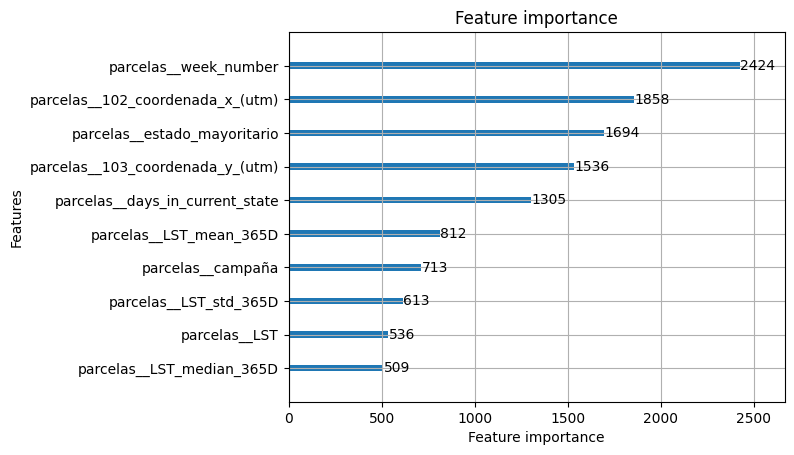

In [29]:
model = evaluate_gbm_model(X_train, y_train, X_test, y_test, models_metric_results)

In [30]:
feature_importance = model.feature_importance(importance_type='gain')

In [31]:
normalized_importance = feature_importance / np.sum(feature_importance)

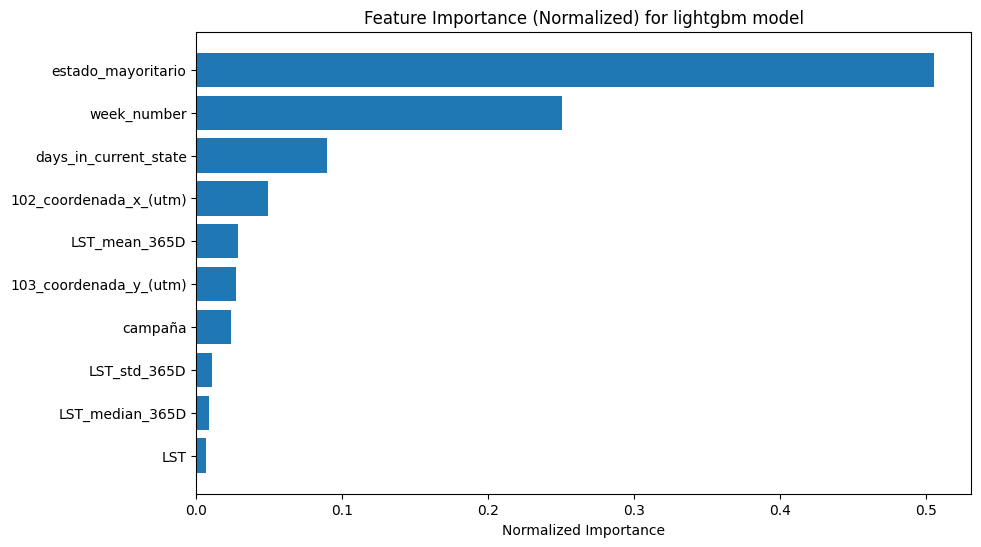

In [32]:
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(normalized_importance)
plt.barh(range(len(sorted_idx)), normalized_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i][len("parcelas_") + 1:] for i in sorted_idx])
plt.xlabel('Normalized Importance')
plt.title('Feature Importance (Normalized) for lightgbm model')
plt.show()

Best model results so far.

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 6
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.7943422580177043
INFO:src.metrics:mse: 0.22676316935132781
INFO:src.metrics:precision_for_class: [0.89556039 0.70275688 0.62940226 0.81408141]
INFO:src.metrics:recall_for_class: [0.87768363 0.75363588 0.60827479 0.36009732]
INFO:src.metrics:f1_for_class: [0.8865319  0.72730765 0.6186582  0.49932524]
INFO:src.metrics:confusion_matrix:
[[50652  6859   198     2]
 [ 5773 28397  3492    18]
 [  129  4740  7792   149]
 [    5   412   898   740]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7464071721403793
INFO:src.metrics:mse: 0.2871559219714376
INFO:src.metrics:precision_for_class: [0.87160675 0.64110691 0.58608573 0.56147541]
INFO:src.metrics:recall_for_class: [0.82881312 0.71736462 0.62308554 0.18975069]
INFO:src.metrics:f1_for_class: [0.84967145 0.6770954  0.60401955 0.28364389]
IN

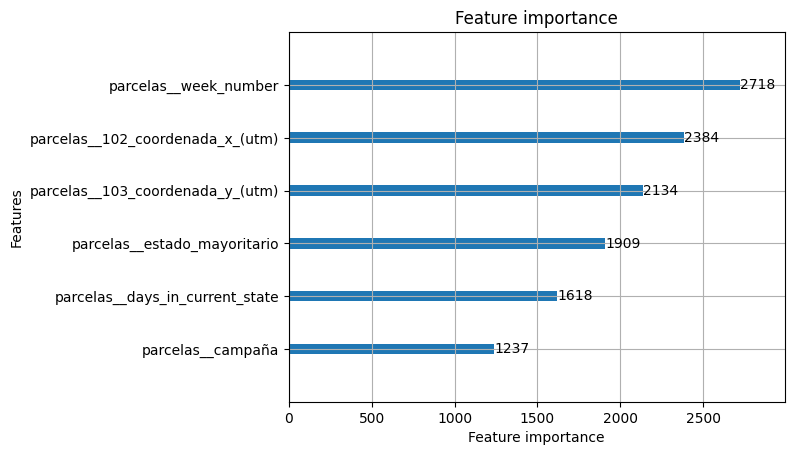

In [48]:
parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

# SELECTED_METEO_COLS = ["LST"]
# SELECTED_DAYS = ["365D"]
# SELECTED_STATS = ["mean", "std", "median"]

# meteo_cols = [
#     f"{col}_{stat}_{day}"
#     for col in SELECTED_METEO_COLS
#     for day in SELECTED_DAYS
#     for stat in SELECTED_STATS
# ]

for col in SELECTED_METEO_COLS:
    meteo_cols.append(col)

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=[]
)

evaluate_gbm_model(X_train, y_train, X_test, y_test)

Model performs worse without LST meteo features.

## Best model

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_57083/2551414947.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 10
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lgb_with_selected_features_train:
INFO:src.metrics:accuracy: 0.7993306486721811
INFO:src.metrics:mse: 0.22005151647075896
INFO:src.metrics:precision_for_class: [0.89618218 0.71174306 0.63830124 0.83752621]
INFO:src.metrics:recall_for_class: [0.88101055 0.75456476 0.62888368 0.38880779]
INFO:src.metrics:f1_for_class: [0.88853161 0.73252863 0.63355747 0.53107345]
INFO:src.metrics:confusion_matrix:
[[50844  6668   199     0]
 [ 5759 28432  3462    27]
 [  126  4500  8056   128]
 [    5   347   904   799]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lgb_with_selected_features_test:
INFO:src.metrics:accuracy: 0.7476235527323513
INFO:src.metrics:mse: 0.27958733162139027
INFO:src.metrics:precision_for_class: [0.86795887 0.64121769 0.59095841 0.6969697 ]
INFO:src.metrics:recall_for_class: [0.83177815 0.72404856 0.61038476 0.15927978]
INFO:src.metrics:f1_for_class: [0.84948343 0.68012044 0.60051452 0.25930101]
I

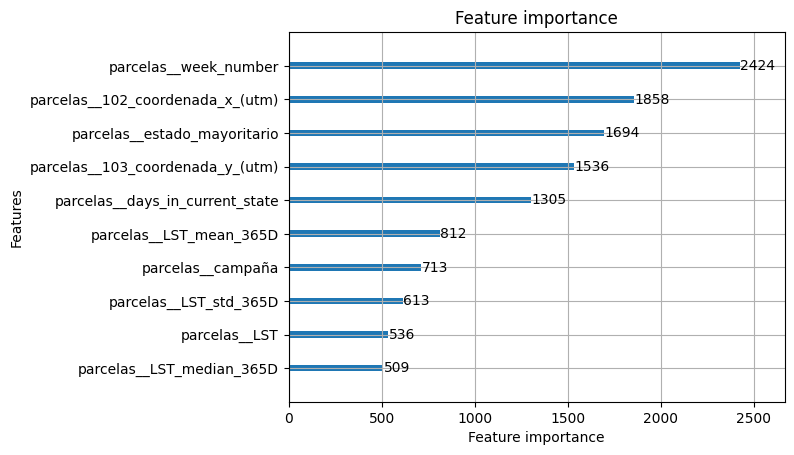

In [49]:
parcelas_cols = [
    "estado_mayoritario",
    "week_number",
    "days_in_current_state",
    "campaña",
    "102_coordenada_x_(utm)",
    "103_coordenada_y_(utm)",
]

SELECTED_METEO_COLS = ["LST"]
SELECTED_DAYS = ["365D"]
SELECTED_STATS = ["mean", "std", "median"]

meteo_cols = [
    f"{col}_{stat}_{day}"
    for col in SELECTED_METEO_COLS
    for day in SELECTED_DAYS
    for stat in SELECTED_STATS
]

for col in SELECTED_METEO_COLS:
    meteo_cols.append(col)

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=parcelas_cols, columns_meteo=meteo_cols
)

evaluate_gbm_model(X_train, y_train, X_test, y_test)

In [ ]:
def evaluate_gbm_model(X_train, y_train, X_test, y_test):
    train_data = lgb.Dataset(X_train, label=np.array(y_train))
    test_data = lgb.Dataset(X_test, label=np.array(y_test), reference=train_data)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y_train)),
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100,
        valid_sets=[train_data, test_data],
        # early_stopping_rounds=10
    )

    evaluate_configuration(model, "lgb_with_selected_features", X_train, y_train, X_test, y_test, evaluation_metrics)
    lgb.plot_importance(model)
    plt.show()

In [51]:
parcelas_cols + meteo_cols

['estado_mayoritario',
 'week_number',
 'days_in_current_state',
 'campaña',
 '102_coordenada_x_(utm)',
 '103_coordenada_y_(utm)',
 'LST_mean_365D',
 'LST_std_365D',
 'LST_median_365D',
 'LST']

# Conclusions
- Obtained a model that outperforms the baseline. This is the lightgbm model.
- The predictive features used are: ['estado_mayoritario',
 'week_number',
 'days_in_current_state',
 'campaña',
 '102_coordenada_x_(utm)',
 '103_coordenada_y_(utm)',
 'LST_mean_365D',
 'LST_std_365D',
 'LST_median_365D',
 'LST']
- The metric results of the lightgbm model in test:
  - accuracy: 0.7476235527323513
  - mse: 0.27958733162139027
  - precision_for_class: [0.86795887 0.64121769 0.59095841 0.6969697 ]
  - recall_for_class: [0.83177815 0.72404856 0.61038476 0.15927978]
  - f1_for_class: [0.84948343 0.68012044 0.60051452 0.25930101]
  - confusion_matrix:
    \[[9538 1897   30    2]
     \[1408 5308  606    9]
     \[  40  964 1634   39]
     \[   3  109  495  115]]
- The metric results of the baseline in test:
  - accuracy: 0.6591431274496553
  - mse: 0.4575393071135739
  - precision_for_class: [0.75273694 0.5095332  0.62638581 0.        ]
  - recall_for_class: [0.83945234 0.52857727 0.42211431 0.        ]
  - f1_for_class: [0.79373325 0.51888056 0.50435171 0.        ]
  - confusion_matrix:
    \[[9626 1799   42    0]
     \[2948 3875  508    0]
     \[ 200 1347 1130    0]
     \[  14  584  124    0]]

## NEXT STEPS:
  - Categorical features were not used, their usage could improve the model.
  - The treatment for missing values in the meteo dataset was LOCF, try with\
    different approaches. Same for numerical features in the parcelas dataset,\
    where imputation with the mean was used.
  - Create more features. In our model, the features that we created were\
    the most important features when making a prediction.
  - Use the entire dataset given. The parcelas and meteo data used in this\
    experimentation was between 2018 and 2022 (inclusive), but did not use\
    the 2023 data, as it was given much later.

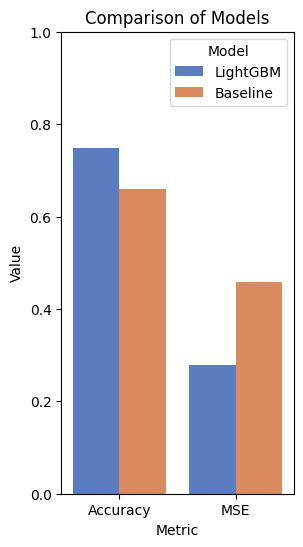

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined lightgbm_test_metrics and baseline_test_metrics dictionaries
lightgbm_test_metrics = models_metric_results["lgb_with_selected_features"]["test"]
baseline_test_metrics = models_metric_results["baseline"]["test"]

# Define the data
data = pd.DataFrame({
    'Model': ['LightGBM', 'Baseline'],
    'Accuracy': [lightgbm_test_metrics["accuracy"], baseline_test_metrics["accuracy"]],
    'MSE': [lightgbm_test_metrics["mse"], baseline_test_metrics["mse"]]
})

# Melt the dataframe to long format
data_melted = data.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(3, 6))
sns.barplot(data=data_melted, x='Metric', y='Score', hue='Model', palette='muted')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of Models')
plt.legend(title='Model')
plt.ylim(0, 1.0)
# Show plot
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


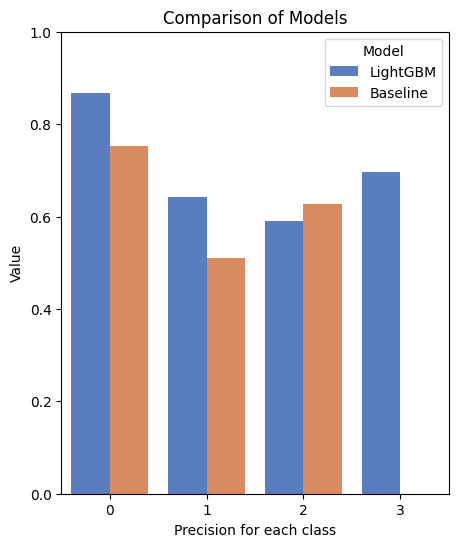

In [70]:
# Define the data
data = pd.DataFrame({
    'Model': ['LightGBM', 'Baseline'],
    '0': [lightgbm_test_metrics["precision_for_class"][0], baseline_test_metrics["precision_for_class"][0]],
    '1': [lightgbm_test_metrics["precision_for_class"][1], baseline_test_metrics["precision_for_class"][1]],
    '2': [lightgbm_test_metrics["precision_for_class"][2], baseline_test_metrics["precision_for_class"][2]],
    '3': [lightgbm_test_metrics["precision_for_class"][3], baseline_test_metrics["precision_for_class"][3]],
})

# Melt the dataframe to long format
data_melted = data.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(5, 6))
sns.barplot(data=data_melted, x='Metric', y='Score', hue='Model', palette='muted')

# Add labels and title
plt.xlabel('Precision for each class')
plt.ylabel('Value')
plt.title('Comparison of Models')
plt.legend(title='Model')
plt.ylim(0, 1.0)
# Show plot
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.0, 1.0)

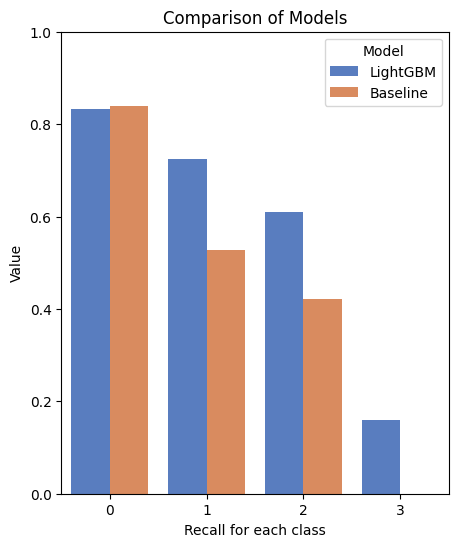

In [71]:
# Define the data
data = pd.DataFrame({
    'Model': ['LightGBM', 'Baseline'],
    '0': [lightgbm_test_metrics["recall_for_class"][0], baseline_test_metrics["recall_for_class"][0]],
    '1': [lightgbm_test_metrics["recall_for_class"][1], baseline_test_metrics["recall_for_class"][1]],
    '2': [lightgbm_test_metrics["recall_for_class"][2], baseline_test_metrics["recall_for_class"][2]],
    '3': [lightgbm_test_metrics["recall_for_class"][3], baseline_test_metrics["recall_for_class"][3]],
})

# Melt the dataframe to long format
data_melted = data.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(5, 6))
sns.barplot(data=data_melted, x='Metric', y='Score', hue='Model', palette='muted')

# Add labels and title
plt.xlabel('Recall for each class')
plt.ylabel('Value')
plt.title('Comparison of Models')
plt.legend(title='Model')
plt.ylim(0, 1.0)
# Show plot